In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unseen-data/PXL_20250208_1229178382.jpg
/kaggle/input/unseen-data/images.jpg
/kaggle/input/skindiseasedataset/Readme.md
/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test/Benign_tumors/dermatofibroma-103.jpeg
/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test/Benign_tumors/calcifying-epithelioma-7.jpeg
/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test/Benign_tumors/epidermal-cyst-147.jpeg
/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test/Benign_tumors/dermatofibroma-117.jpeg
/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test/Benign_tumors/porokeratosis-70.jpeg
/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test/Benign_tumors/skin-tags-polyps-44.jpeg
/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test/Benign_tumors/acquired-digital-fibrokeratoma-3.jpeg
/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test/Benign_tumors/connective-tissue-nevus-1.jpeg
/kaggle/input/skindiseasedataset/SkinDis

In [2]:
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
dataset_path = os.listdir('/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test')
print (dataset_path)  #what kinds of classes are in this dataset

print("Types of classes labels found: ", len(dataset_path))

['Benign_tumors', 'Unknown_Normal', 'Tinea', 'Eczema', 'Actinic_Keratosis', 'Vascular_Tumors', 'Acne', 'Infestations_Bites', 'Rosacea', 'Seborrh_Keratoses', 'Moles', 'Vitiligo', 'SkinCancer', 'Vasculitis', 'Lichen', 'Candidiasis', 'DrugEruption', 'Sun_Sunlight_Damage', 'Bullous', 'Warts', 'Psoriasis', 'Lupus']
Types of classes labels found:  22


In [5]:
import random
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['Benign_tumors', 'Unknown_Normal', 'Tinea', 'Eczema', 'Actinic_Keratosis', 'Vascular_Tumors',
               'Acne', 'Infestations_Bites', 'Rosacea', 'Seborrh_Keratoses', 'Moles', 'Vitiligo', 'SkinCancer',
               'Vasculitis', 'Lichen', 'Candidiasis', 'DrugEruption', 'Sun_Sunlight_Damage', 'Bullous', 'Warts', 'Psoriasis', 'Lupus']

def set_seeds(seed: int=42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)


set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 229MB/s] 


In [6]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(8, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [8, 3, 224, 224]     [8, 22]              768                  Partial
├─Conv2d (conv_proj)                                         [8, 3, 224, 224]     [8, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [8, 197, 768]        [8, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [8, 197, 768]        [8, 197, 768]        --                   --
│    └─Sequential (layers)                                   [8, 197, 768]        [8, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [8, 197, 768]        [8, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [8, 197, 768]        [8, 1

In [7]:
train_dir = '/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/train'
test_dir = '/kaggle/input/skindiseasedataset/SkinDisease/SkinDisease/test'

In [8]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [10]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)

In [11]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [12]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


In [13]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [15]:
# Create optimizer and loss function
optimizer = torch.optim.AdamW(params=pretrained_vit.parameters(), lr=3e-4, weight_decay=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=30,
                                      device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0884 | train_acc: 0.6718 | test_loss: 1.3233 | test_acc: 0.5890
Epoch: 2 | train_loss: 1.0732 | train_acc: 0.6810 | test_loss: 1.3142 | test_acc: 0.5960
Epoch: 3 | train_loss: 1.0595 | train_acc: 0.6821 | test_loss: 1.3153 | test_acc: 0.5967
Epoch: 4 | train_loss: 1.0471 | train_acc: 0.6872 | test_loss: 1.3146 | test_acc: 0.5941
Epoch: 5 | train_loss: 1.0359 | train_acc: 0.6909 | test_loss: 1.3055 | test_acc: 0.5960
Epoch: 6 | train_loss: 1.0242 | train_acc: 0.6944 | test_loss: 1.2991 | test_acc: 0.5890
Epoch: 7 | train_loss: 1.0141 | train_acc: 0.6974 | test_loss: 1.2963 | test_acc: 0.5967
Epoch: 8 | train_loss: 1.0046 | train_acc: 0.7026 | test_loss: 1.2989 | test_acc: 0.6011
Epoch: 9 | train_loss: 0.9937 | train_acc: 0.7035 | test_loss: 1.2960 | test_acc: 0.5916
Epoch: 10 | train_loss: 0.9846 | train_acc: 0.7056 | test_loss: 1.2971 | test_acc: 0.6082
Epoch: 11 | train_loss: 0.9776 | train_acc: 0.7085 | test_loss: 1.2960 | test_acc: 0.5941
Epoch: 12 | train_l

In [16]:
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

In [17]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

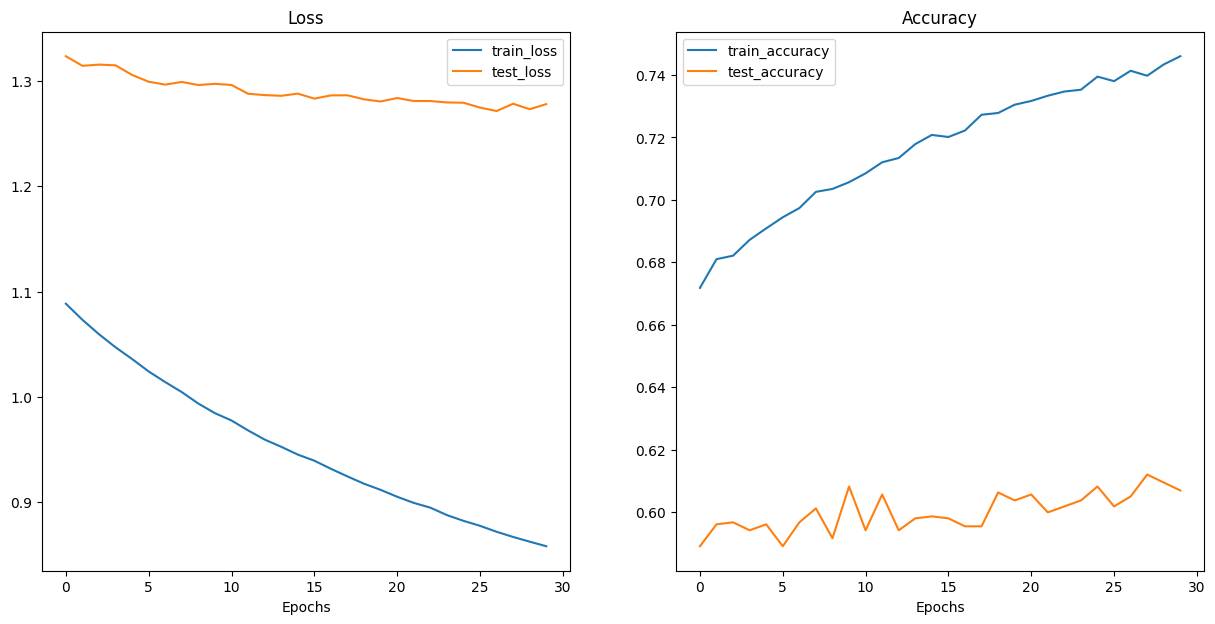

In [18]:
plot_loss_curves(pretrained_vit_results) 

In [22]:
from PIL import Image

def pred_and_plot_image(model, image_path, class_names, device="cuda"):
    # Load image
    image = Image.open(image_path).convert("RGB")
    
    # Apply transformations
    transformed_image = image_transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Set model to eval mode
    model.eval()
    
    with torch.inference_mode():
        # Make prediction
        y_pred = model(transformed_image)
        pred_label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1).item()
    
    # Get class name
    pred_class = class_names[pred_label]

    # Plot the image with the predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Prediction: {pred_class}", fontsize=14)
    plt.axis("off")
    plt.show()


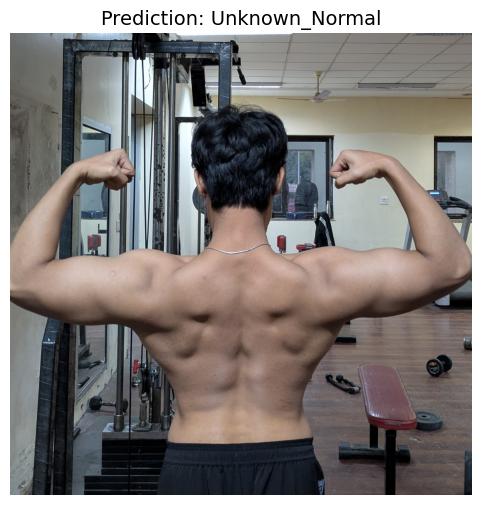

In [23]:
# Setup custom image path
custom_image_path = "/kaggle/input/unseen-data/PXL_20250208_1229178382.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

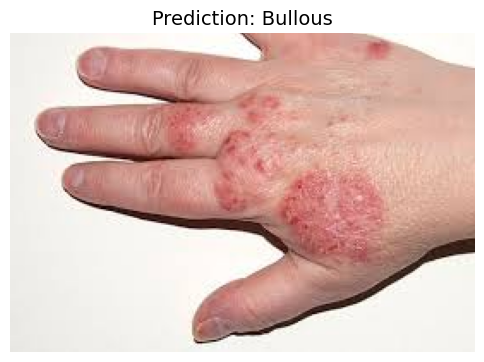

In [24]:
# Setup custom image path
custom_image_path = "/kaggle/input/unseen-data/images.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)